# 5層で正則化を試す
物性値は
$\theta_F = \pi/100$,$\eta_F=1\degree$とする。

In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

env: TOKEN=*************************************
Cloning into 'MOD2NN'...
remote: Enumerating objects: 1122, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1122 (delta 138), reused 217 (delta 91), pack-reused 829
Receiving objects: 100% (1122/1122), 37.21 MiB | 21.45 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Mounted at /content/drive


In [1]:
import time
import os
import json
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.7e-3 #@param {type:"number"}

In [5]:
def create_model(**kwargs):
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    theta = np.pi / 100
    eta = np.arctan(1.0*np.pi/100)
    l1 = kwargs["l1"]
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.SymmetricShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.SymmetricShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.SymmetricShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.SymmetricShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.SymmetricShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand')(x)
    x = FaradayRotationByStokes(shape)(x)
    x = MNISTDetector(10)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
l1_list = np.array([1.0, 1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4,1.0e-5,1.0e-6,1.0e-7,1.0e-9,1.0e-9, 0])
for i, l1 in enumerate(l1_list):
    model = create_model(l1=l1)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220823_" + str(i+1)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [ ]:
path = '/content/drive/MyDrive/D2NN/trained_model/20220823_*'
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
acc_list = []
for path in files:
  model = tf.keras.models.load_model(path)
  acc = model.evaluate(x_test, y_test)

  bi_model = tf.keras.models.load_model(path)
  pattern = r'mo'
  mo_layers = []
  save = False
  each_save = False
  for layer in bi_model.layers:
      result = re.match(pattern, layer.name)
      if result:
          mo_layers.append(layer)

  for layer in mo_layers:
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      w[0] = bi_w
      layer.set_weights(w)

  bi_acc = bi_model.evaluate(x_test, y_test)
  acc_list.append([acc[1], acc[0], bi_acc[0], bi_acc[1]])

In [ ]:
acc = np.array(acc_list)
df = pd.DataFrame(np.hstack([acc, l1_list.reshape([-1,1])]), columns=["acc", "loss","bi_loss", "bi_acc", "l1"])
df.to_csv("./acc_list.csv")

In [15]:
df = pd.read_csv("acc_list.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'acc_list.csv'

あんまり違いが出ないので、seed値変えて試してみる。

In [8]:
path = '/content/drive/MyDrive/D2NN/trained_model/20220823_*'
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
acc_list = []
for path in files:
  model = tf.keras.models.load_model(path)
  acc = model.evaluate(x_test, y_test)

  bi_model = tf.keras.models.load_model(path)
  pattern = r'mo'
  mo_layers = []
  save = False
  each_save = False
  for layer in bi_model.layers:
      result = re.match(pattern, layer.name)
      if result:
          mo_layers.append(layer)

  for layer in mo_layers:
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      w[0] = bi_w
      layer.set_weights(w)

  bi_acc = bi_model.evaluate(x_test, y_test)
  acc_list.append([acc[1], bi_acc[1]])

313/313 [==============================] - 3s 9ms/step - loss: 0.5400 - accuracy: 0.8427


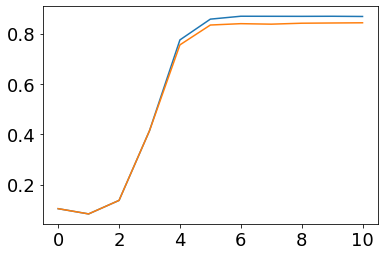

In [9]:
df = pd.read_csv("acc_list.csv")

plt.plot(df["acc"])
plt.plot(df["bi_acc"])